# Numerically Integrating the SHO model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [16]:
x0 = 1.0 ## Initial position
v0 = 0.0 ## Initial velocity

omega = 2 ## Angular freq. of SHO

tf = 20 ## Model time

In [17]:
def AnalyticalSolutionSHO(tf, deltat, amp, omega, t0 = 0, phase = 0):
    
    if t0 < tf:
        
        t = np.arange(t0,tf,deltat) ## equal steps
        x = amp*np.cos(omega*t+phase)
        
        return t,x
    
    else:
        
        raise ValueError('Final time is before start time.')

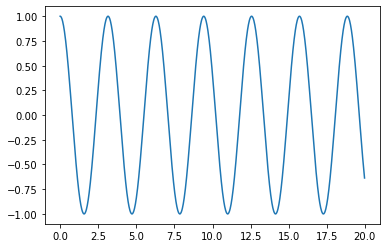

In [18]:
t,x = AnalyticalSolutionSHO(tf, 0.02, x0, omega)
plt.plot(t,x)